Force Sensor

In [45]:
import nidaqmx 
import atiiaftt as ati
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CALFILEPATH = "FT44764\FT44764.cal"
INDEX = 1

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()
    reading = task.read()

transform = [0,0,-85,0,0,0]

#Bias
sensor = ati.FTSensor()
cal = sensor.createCalibration(CALFILEPATH, INDEX)
sensor.setForceUnits("N".encode("utf-8"))
sensor.setTorqueUnits("N-m".encode("utf-8"))
sensor.setToolTransform(transform, "mm".encode("utf-8"), "deg".encode("utf-8"))

sensor.bias(bias)
output = sensor.convertToFt(reading)
output

[-0.01791515201330185,
 -0.04283382371068001,
 -0.007776092272251844,
 0.0021831633057445288,
 -0.001187656307592988,
 0.0004738940915558487]

Test Sensor

In [3]:
current_time = time.time()
duration = 5
readings = []
while time.time() < current_time+duration:
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")

        reading = sensor.convertToFt(task.read())
        print(reading)
        readings.append(reading)

print("Number of Data", len(readings))

[-0.00864542368799448, -0.03749117627739906, -0.01206250675022602, 0.0017880061641335487, -0.0006382895517162979, 0.00032852921867743134]
[-0.004028025083243847, -0.029439065605401993, -0.02446046844124794, 0.0013201702386140823, -0.0004992966423742473, 0.0003309604071546346]
[-0.006580411456525326, -0.02547343820333481, 0.004317763727158308, 0.0011448293225839734, -0.00035228399792686105, 0.0001235472154803574]
[-0.008886856958270073, -0.02937348186969757, 0.0043786135502159595, 0.0014301384799182415, -0.0009308942244388163, 0.00012342000263743103]
[-0.01110612042248249, -0.028138700872659683, 0.0004060491919517517, 0.0011044899001717567, -0.0008234162232838571, 0.0001918071211548522]
[-0.01341116614639759, -0.026833049952983856, -0.003542718244716525, 0.0008957033278420568, -0.0009273341856896877, 0.00048023296403698623]
[-0.013293314725160599, -0.04278023540973663, -0.00795107800513506, 0.0022932959254831076, -0.0010486312676221132, 0.0002575174148660153]
[-0.02465207502245903, -0.0

Initiallize Motor

In [4]:
import numpy as np
import datetime as dt
import csv
import matplotlib.pyplot as plt
import serial
from time import sleep


ENTER = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFC])
EXIT = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFD])
ZERO = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFE])


# AK70-10 24V Motor Limit
P_MIN = -12.5
P_MAX = 12.5
V_MIN = -50  
V_MAX = 50
T_MIN = -25 
T_MAX = 25
KP_MIN = 0
KP_MAX = 500
KD_MIN = 0
KD_MAX = 5

Function

In [16]:
def unpack(data):
    id = data[0]
    pos = ((data[1]*(P_MAX-P_MIN))/(pow(2,16)-1)) + P_MIN
    vel = ((data[2]*(V_MAX-V_MIN))/(pow(2,12)-1)) + V_MIN
    tor = ((data[3]*(T_MAX-T_MIN))/(pow(2,12)-1)) + T_MIN
    return id, pos, vel, tor

def receive():
    global dT, q1_old, q2_old
    # Read the response from the serial port
    received = ser.readline().decode().split()      

    # Print the received bytes
    # print("Received:", received)

    try:
        test = int(received[0])
        response = [int(x) for x in received]
        [id, p, v, t] = unpack(response)

        if id == 1:
            p = -round(p,3)
            t = -t
            if dT == 0:
                v = 0
            else:
                v = round((p - q1_old)/dT,2)
        
        else:
            p = round(p,3)
            t = t
            if dT == 0:
                v = 0
            else:
                v = round((p-q2_old)/dT,2)

        # print the response from the Arduino
        # print([id, p, v, t])

    except (IndexError, ValueError):
        id = None
        p = 0
        v = 0
        t = 0
    return id, p, v, t

def pack_cmd(p_des, v_des, t_ff, kp, kd):
    bufs = []
    def float_to_uint(val, val_min, val_max, bits):
        val_norm = (val - val_min) / (val_max - val_min)
        val_int = int(round(val_norm * ((1 << bits) - 1)))
        return val_int
    
    p_int = float_to_uint(p_des, P_MIN, P_MAX, 16)
    v_int = float_to_uint(v_des, V_MIN, V_MAX, 12)
    t_int = float_to_uint(t_ff, T_MIN, T_MAX, 12)
    kp_int = float_to_uint(kp, KP_MIN, KP_MAX, 12)
    kd_int = float_to_uint(kd, KD_MIN, KD_MAX, 12)
    
    bufs.append((p_int >> 8) & 0xFF)
    bufs.append(p_int & 0xFF)
    bufs.append((v_int >> 4) & 0xFF)
    bufs.append(((v_int & 0xF) << 4) | ((kp_int >> 8) & 0xF))
    bufs.append(kp_int & 0xFF)
    bufs.append((kd_int >> 4) & 0xFF)
    bufs.append(((kd_int & 0xF) << 4) | ((t_int >> 8) & 0xF))
    bufs.append(t_int & 0xFF)

    return bufs

Construct Serial Connection

In [6]:
# open the serial port
ser = serial.Serial('COM5', 115200, timeout=1)


Set Zero

In [9]:
print("Begining")


q1_old = 0
pos2_old = 0
dT = 0

#M1
print("Starting Zero Position M1")
ser.write(bytes([0x01])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x01])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()



#M2
print("Starting Zero Position M2")
ser.write(bytes([0x02])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x02])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()

print("Finishing Zero Position")


Begining
Starting Zero Position M1
Starting Zero Position M2
Finishing Zero Position


Enter Motor and Re-bias Force Sensor

In [57]:
##Motor

#M1
print("Starting Enter Motors")
ser.write(bytes([0x01])+ENTER)
[id, p, v, t] = receive()
if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

#M2
ser.write(bytes([0x02])+ENTER)
[id, p, v, t] = receive()

if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

q1_old = q1
q2_old = q2


##Sensor

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()

sensor.bias(bias)

Starting Enter Motors


Running

In [58]:
start_time = dt.datetime.today().timestamp()
t = 0
l1 = 0.275
l2 = 0.24
l4 = 0.01
q0 = np.deg2rad(18)
logs = list()
motor_logs = list()
readings = list()




print("Start Controling")
while t < duration:
    start_time = dt.datetime.today().timestamp()

    log = list()
    log.append(t)

    q1_old = q1
    q2_old = q2



    T1 = 0.5
    T2 = 0.5

    
    
    log.append(T1)
    log.append(T2)


    command1 = bytes(pack_cmd(0,0,-T1,0,0)) #(pos,vel,torque,kp,kd)
    command2 = bytes(pack_cmd(0,0,T2,0,0)) #(pos,vel,torque,kp,kd)

    #M1
    ser.write(bytes([0x01])+command1)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t

    #M2
    ser.write(bytes([0x02])+command2)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t

    log.append(t1)
    log.append(t2)

    log.append(q1)
    log.append(q2)

    x = l1*np.sin(q1) + l2*np.cos(q2)
    y = l1*np.cos(q1) - l2*np.sin(q2)

    log.append(x)
    log.append(y)


    #Estimate CF
    A = q0-q1+2*q2
    B = q0-q1
    C = q0-2*q1+q2
    D = q0+q2
    Fx = -((T1*l2*(np.sin(A)+np.sin(B))+T2*l1*(np.sin(C)-np.sin(D)))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))
    Fy = (T1*l2*(np.cos(B)+np.cos(C))+T2*l1*(np.cos(D)-np.cos(A))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))    

    log.append(Fx)
    log.append(Fy)

    motor_logs.append(log)


    #Sensor
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
        reading = sensor.convertToFt(task.read())

  
    #print(reading)
    log.append(reading)
    readings.append(reading)

    logs.append(log)
    
    #print("Progress", f'{round(t/duration*100,3)}%')
    dT = dt.datetime.today().timestamp()-start_time
    t+= dT

ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()
    

print("finish")
# print(logs)


Start Controling
finish


In [59]:
print("Data Sample Size", len(readings))
COLUMNS = ["Force X", "Force Y", "Force Z", "Torque X", "Torque Y", "Torque Z"]
readings
arrays = np.array([np.array(item) for item in readings])

arrays_transpose = arrays.transpose()
df = pd.DataFrame([])
for i in range(len(COLUMNS)):
    df[COLUMNS[i]] = arrays_transpose[i]

Data Sample Size 142


In [61]:
print(motor_logs)
logs_COLUMNS = ["Time", "T1", "T2", "t1", "t2", "q1", "q2", "x", "y", "Fx", "Fy", "FT"]

logs_arrays = np.array([np.array(item) for item in motor_logs])

logs_arrays_transpose = logs_arrays.transpose()
df = pd.DataFrame([])
for i in range(len(logs_COLUMNS)):
    df[logs_COLUMNS[i]] = logs_arrays_transpose[i]

[[0, 0.5, 0.5, -0.544, 0.289, 0.08771730001588954, 0.16690393111667812, -3.313732019337878, 1.2350286423597359, [0.025403982028365135, 3.14591121673584, 0.812201738357544, -0.01423271931707859, -0.01932590641081333, -0.07703165709972382]], [0.0323939323425293, 0.5, 0.5, -0.483, 0.332, 0.09917369626045969, 0.16531726756421247, -3.1731295468071687, 1.2363405110196135, [0.7184060215950012, 3.0263874530792236, 1.5647716522216797, -0.06934506446123123, 0.020736169070005417, -0.1112382560968399]], [0.06494903564453125, 0.5, 0.5, -0.48, 0.332, 0.09990489452279575, 0.1656993324679764, -3.164408709999345, 1.230293760384514, [-2.0075998306274414, -0.7697435021400452, 0.882087230682373, -0.13452576100826263, -0.09490172564983368, -0.06746259331703186]], [0.10497093200683594, 0.5, 0.5, -0.48, 0.334, 0.09974799229631776, 0.16524570088339893, -3.1659375179590876, 1.236042971612128, [-2.4220874309539795, -0.7677474021911621, 0.2648811340332031, 0.1634809672832489, -0.17918631434440613, 0.070084176957

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [54]:
df

,Force X,Force Y,Force Z,Torque X,Torque Y,Torque Z
0,-4.465045,1.263170,-0.210418,0.139149,-0.150165,0.144650
1,-2.841351,0.442182,-0.952666,-0.028782,-0.017417,0.031390
2,-2.678245,1.707372,-0.072210,-0.303575,-0.053688,-0.063376
3,-3.367370,-0.895468,-1.168286,-0.098474,-0.155864,0.112513
4,-3.298131,1.147961,-1.126337,0.100730,-0.149648,0.069671
...,...,...,...,...,...,...
140,-4.401019,-2.001774,-1.678080,-0.044869,-0.257183,0.125830
141,-4.419532,-4.776166,-2.388178,0.064155,-0.246451,0.126577
142,-4.032447,-1.817146,-1.324517,-0.186792,-0.270974,0.095156
143,-3.559535,0.525833,-3.415557,-0.488002,-0.213146,-0.047687


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

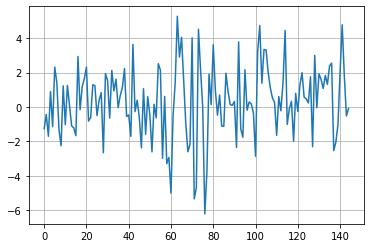

In [55]:
X = df.index
Y = -1*df["Force Y"]
plt.plot(X, Y)
plt.grid()
plt.plot